In [1]:
from collections import defaultdict
import logging
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s: (%(lineno)s) %(levelname)s %(message)s")
import os

import json
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)
import pprint
import networkx as nx

from semeval_fca import find_paths_to_object

Populating the interactive namespace from numpy and matplotlib


# Freq cutoff

In [2]:
task_dir = '/mnt/permanent/Language/English/Data/SemEval/2018/Hypernym/'

In [3]:
freq_filen = os.path.join(task_dir, 'frequency_lists/1A_english_frequencylist.txt')
freqs = defaultdict(int)
freqs.update({l.split("\t")[0]: int(l.split("\t")[1]) for l in open(freq_filen)})

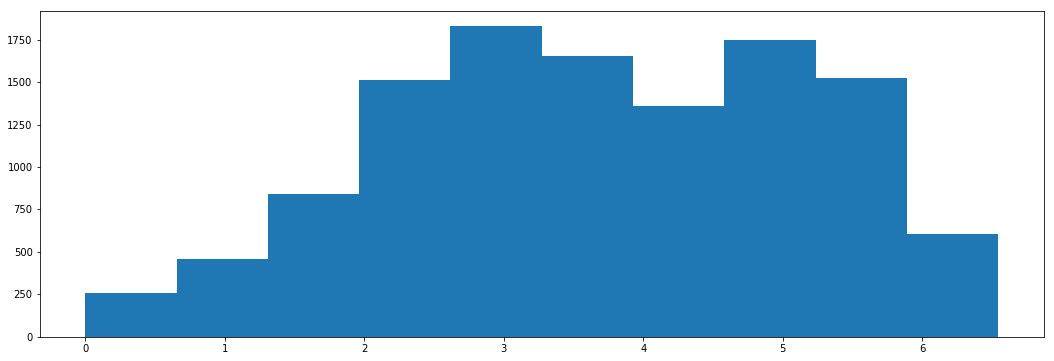

In [4]:
golds = [t for l in open(os.path.join(task_dir, 'test/training/gold/1A.english.training.gold.txt'))
         for t in l.strip().split('\t')]
plt.hist([0 if g not in freqs else np.log10(freqs[g]) for g in golds])
plt.show()

In [5]:
vocab = set([l.strip() for l in open(os.path.join(task_dir, 'test/vocabulary/1A.english.vocabulary.txt'))])

words_left = lambda x, threshold, vocabulary: [word for word, f in x.items() if f > threshold and word in vocabulary]



for threshold in [10, 100, 1000, 10000]:
    s = set(words_left(freqs, threshold, vocab))
    print('{}\t{}/{}\t{}/{}'.format(threshold, len(s), len(vocab), len([g for g in golds if g in s]), len(golds)))

10	135847/218753	11271/11780
100	76343/218753	10152/11780
1000	32219/218753	7661/11780
10000	9807/218753	5046/11780


# Tree exploration

In [6]:
logging.inf('')
J = json.load(open(
    '/mnt/store/hlt/Work/hypernym18-SemEval/concept_tree/1A_UMBC_tokenized.txt_100_sg.vec.gz_True_1000_0.2_unit_True_vocabulary_filtered_reduced.cxt.json'))
logging.inf('')

In [7]:
paths, nodes, depths = find_paths_to_object(J, 'dhow')

mind3 visszaadott lista olyan hosszú lesz, mint ahányféleképp el lehetett jutni a gyökérből egy olyan csúcsig, amiben megtalálható volt a lekérdezett szó

* a `path` ezeknek az utaknak a visszafejtését tartalmazza, 
* a `nodes` magát azt a csúcsot, ahol az i. út véget ért
* a `depths` pedig azt hogy a gyökértől milyen mélyen helyezkedik el ez a bizonyos csúcs


elvileg redundáns is, tehát a `paths` i. elemében egy olyan listát kell találj, ami egy gyökérben végződő utat kódol, és a `depths` i. értékéül épp ennek az útnak a hosszát kell lásd

In [8]:
def my_print(words, max_len=7):
    words = sorted(words, key=lambda word: freqs[word], reverse=True)
    ans = ' '.join(str(i) for  i in words[:max_len])
    len_ = len(words)
    if len_ > max_len:
        ans += '... ({})'.format(len_)
    return '{:.2} {}'.format(log10(freqs[words[0]]), ans)

In [9]:
log10(freqs['how'])

6.4428936410123194

In [10]:
"""
Prints pathes from the deepest (most specific) occurrence to the full set.
"""
max_depth = -1
for path, node, depth in reversed(list(zip(paths, nodes, depths))):
    if depth < max_depth:
        break
    else:
        max_depth = depth
    print(
        #'dhow' in node, # == True 
        my_print(node), depth)
    for node2 in path[:-1]:
        #print('{}\t{}\t{}'.format(my_print(node2['attributes']), node2['Node'], my_print(node2['own_objects'])))
        print('{}'.format(my_print(node2['own_objects'], max_len=11)))
    print()


3.0 seafaring coastwise dhow unladen windjammer undecked flota... (11) 4
3.0 plying breadfruit flat-bottomed whalebone sampan sailcloth kapa vaka argosy casco butter-box... (15)
3.6 pearl stilt cocoanut cowries cowry swiftlet
3.5 mahogany jade sultan dey mulberry brocade mother-of-pearl dutch macaw tortoiseshell jades... (31)

2.1 dhow wharfside tunnage 4
3.5 rum kapok salter vapored seal_oil whale_oil
2.2 whaleboat supercargo kapa chantey sennit lubberly butter-box wooden_boat wooden_shoe balsa_raft breadfruit_tree
3.5 mahogany jade sultan dey mulberry brocade mother-of-pearl dutch macaw tortoiseshell jades... (31)

2.2 supertanker dhow bilgewater oil_tanker 4
0.7 ranson Tropical_Storm_Cindy
4.2 whale shark ashore fisherman jetty sardines prow porpoise keels breadfruit conga... (50)
4.4 coral reef turtle crabs pelagic lizard crocodile seaweed turquoise octopus starfish... (176)

3.6 cruising dhow pleasure_boat 4
4.2 diving sailing ballast Harbour lighthouse mooring keel bulkhead seafa

In [11]:
paths[0]

[{'Node': 0, 'attributes': [], 'own_objects': []}]

In [12]:
nodes[0][:8]

['watercraft',
 'edgily',
 'nitro',
 'road_racing',
 'sports_car',
 'dinky-di',
 'jalopy',
 'cupholder']

In [13]:
depths[0]

1

# Lattice exploration

In [14]:
dag = nx.read_gpickle('/mnt/permanent/home/makrai/project/hypernym18-SemEval/top500words.gpickle')

In [16]:
dag.number_of_nodes(), dag.number_of_edges()

(196, 446)

In [17]:
print(dag.nodes['node175']['label'])

175|0th|n816\nn288\nn106\nn463\nn954\nn527\nn150\nn226\nn533\nn36
